RAINSTORM

## Seize labels

- This notebook will help us visualize the results from labeled videos of an experiment

#### Requirements:

- The position files (processed by [2a-Prepare_positions](2a-Prepare_positions.ipynb))
- The movement files (processed by [2b-Geometric_analysis](2b-Geometric_analysis.ipynb))
- The labels, geolabels or autolabels files (labeled by [1-Behavioral_labeler](1-Behavioral_labeler.ipynb), [2b-Geometric_analysis](2b-Geometric_analysis.ipynb) or [3b-Automatic_analysis](3b-Automatic_analysis.ipynb))

---
#### Load the necessary modules

In [1]:
from pathlib import Path
import rainstorm.seize_labels as rst

---
#### 1. State your project path and experiment details in the params file
Define the path to the experiment folder, and the path to the parameters file.

Go to the params.yaml file and specify the parameters in the *seize_labels* section.

In [2]:
base = Path(r'C:\Users\dhers\Desktop\Rainstorm')
folder_path = base / r'examples\NOR'
params_file = folder_path / 'params.yaml'

---
#### 2. Visualize the behavioral labels on a video

The following function combines the position data, the behavioral labels, and the original video recording to create a video with the labels overlaid.

The video can be built both using the original video file or not... try removing the `video_path` argument from the function call to see the difference.

In [3]:
example_path = rst.choose_example_positions(params_file, look_for = 'TS')

Found 10 file(s) matching 'TS'. Using: 'NOR_TS_02_positions.csv'


In [4]:
video_name = example_path.name.replace('_positions.csv', '.mp4')
video_path = folder_path / 'TS_videos' / video_name
rst.create_video(params_file, example_path, video_path)

Starting video creation process for: NOR_TS_02_positions.csv
Video created successfully: C:\Users\dhers\Desktop\Rainstorm\examples\NOR\NOR_TS_02_video.mp4


---
#### 3. Plot individual exploration


Exploration is a dynamic behavior, and experiment results can change a lot depending on the timeframe chosen for analysis. A first step to understanding the exploration dynamics is to plot the evolution of the cumulative exploration time.

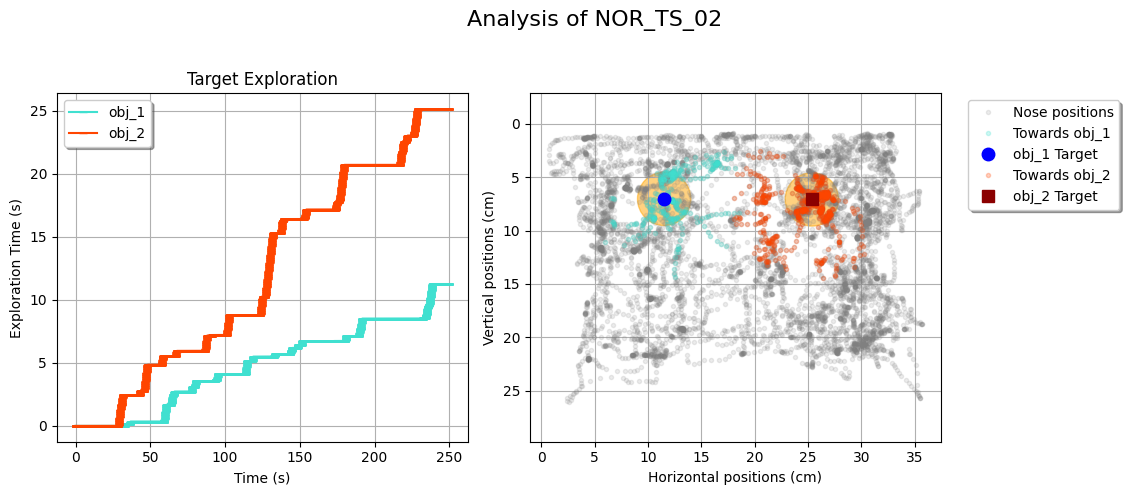

In [5]:
rst.plot_mouse_exploration(params_file, example_path)

This plot shows the behavior of a single subject, and does not take into account the role of each exploratory target. To build more elaborate plots, we need to inform the groups and target roles for each mice and trial.

---
#### 4. Create a ‘reference.csv’ file on our experiment folder.
This function will use the groups, trials and target roles we state on the params file to create a ‘reference.csv’ file that will be used to organize the files and plot the experiment results.

In [6]:
reference_path = rst.create_reference_file(params_file)

Reference file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\reference.csv. Use overwrite=True to recreate it.


#### Go to the experiment folder and complete the 'reference.csv' file
If you are using the NOR example folder to try out rainstorm, you will find a copy of the ‘reference.csv’ file **already completed** in the experiment folder.

With the ‘reference.csv’ file complete, you can proceed to the next step where it will be used to create the 'summary' folder.

---
#### 5. Create the 'Summary' folder
This new folder will contain files for each video recording, which will be used to hold all the labels and geometric information.

The groups and objects on the ‘reference.csv’ file will be used to organize the files into subfolders, and the target columns will be renamed according to their role (e.g. Novel and Known).

In [7]:
summary_path = rst.create_summary(params_file)

Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_1\Hab\NOR_Hab_01_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_1\Hab\NOR_Hab_02_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_2\Hab\NOR_Hab_03_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_2\Hab\NOR_Hab_04_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_1\Hab\NOR_Hab_05_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\summary\Group_1\Hab\NOR_Hab_06_summary.csv. Use overwrite=True to recreate it.
Summary file already exists at C:\Users\dhers\Desktop\Rainstorm\

In [ ]:
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex, rgb_to_hsv, hsv_to_rgb

rst.configure_logging()
logger = logging.getLogger(__name__)

def plot_multiple_analyses(
    params_path: Path,
    trial: str,
    plots: list,
    show: bool = True,
    outliers: list[str] = None
) -> None:
    """
    Plot multiple analyses for a single trial side by side as subplots.

    Args:
        params_path: Path to the YAML configuration file containing plotting parameters.
        trial: The specific trial name (e.g., 'NOR_TS_01') for which to generate plots.
        plots: A list of callable functions (e.g., `[lineplot_cumulative_distance, lineplot_cumulative_exploration_time]`)
               that will be used to generate each subplot. Each function in this list
               MUST accept the following arguments:
               `(base_path, group, trial, targets, fps, ax, outliers, group_color, label_type)`.
        show: If True, the generated plots will be displayed interactively.
        outliers: An optional list of filenames (or parts of filenames) to exclude from
                  data processing for any of the plots.
    """
    if outliers is None:
        outliers = []

    params_path = Path(params_path)
    logger.info(f"Starting multiple analyses plotting for trial: {trial} using params from {params_path.name}")

    # --- Load parameters from YAML ---
    try:
        params = rst.load_yaml(params_path)
        output_base_dir = Path(params.get("path"))
        fps = params.get("fps", 30)
        targets = params.get("targets", []) # Default targets from parameters
        seize_labels = params.get("seize_labels", {})
        groups = seize_labels.get("groups", [])
        target_roles_data = seize_labels.get("target_roles", {}) # 'target_roles' maps trials to specific target lists if novelty changes
        label_type = seize_labels.get("label_type", "labels")

        if not groups:
            logger.warning("No groups specified in parameters. No plots will be generated.")
            return

        if not plots:
            logger.warning("No plotting functions provided in 'plots' list. No plots will be generated.")
            return

    except Exception as e:
        logger.error(f"Error loading or parsing parameters from {params_path}: {e}")
        raise

    # --- Setup Figure and Axes ---
    num_plots = len(plots)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 6), sharey=False)
    logger.info(f"Created a figure with {num_plots} subplots.")

    # Ensure axes is always iterable, even for a single subplot
    if num_plots == 1:
        axes = [axes]

    # Define a comprehensive list of base colors for different groups
    base_color_list = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow']

    # --- Iterate through plot functions and groups to create subplots ---
    for ax_idx, ax in enumerate(axes):
        plot_func = plots[ax_idx]
        logger.info(f"Processing subplot {ax_idx+1}/{num_plots} with function: {plot_func.__name__}")

        # Iterate through each group to plot its data on the current subplot
        for group_idx, group in enumerate(groups):
            group_base_color = base_color_list[group_idx % len(base_color_list)] # Assign a unique base color to the current group

            # Determine the relevant targets for the current trial and group
            # Falls back to general 'targets' if specific 'target_roles' not defined for this trial
            novelty_targets = target_roles_data.get(trial)
            if not novelty_targets:
                novelty_targets = targets # Use default targets from params
                logger.debug(f"Specific target roles for trial '{trial}' not found. Using default targets: {targets}")
            else:
                logger.debug(f"Targets for trial '{trial}' defined as: {novelty_targets}")

            try:
                # Call the specific plotting function for the current subplot and group
                # All plot functions passed in `plots` must adhere to this signature.
                plot_func(
                    base_path=output_base_dir,
                    group=group,
                    trial=trial,
                    targets=novelty_targets, # Pass the resolved targets for the trial
                    fps=fps,
                    ax=ax,
                    outliers=outliers,
                    group_color=group_base_color, # Pass the assigned group color
                    label_type=label_type # Pass the label_type
                )
            except Exception as e:
                logger.error(f"Error executing plot function '{plot_func.__name__}' for group '{group}' and trial '{trial}': {e}", exc_info=True)
                ax.set_title(f"Error in {plot_func.__name__.replace('lineplot_', '').replace('plot_', '').replace('_', ' ').title()}\n(Group: {group}, Trial: {trial})", color='red', fontsize=10)
                ax.text(0.5, 0.5, f"Plotting error: {e}",
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax.transAxes, fontsize=8, color='red', wrap=True)
                continue # Continue to the next group/plot even if one fails

        # Set a clear title for each subplot
        # Converts function name (e.g., 'lineplot_cumulative_distance') to a readable title
        readable_title = plot_func.__name__.replace('lineplot_', '').replace('plot_', '').replace('_', ' ').title()
        ax.set_title(readable_title, fontsize=12)

        # Adjust legend position for each subplot to avoid overlap with other plots/titles
        if ax.get_legend() is not None:
            ax.get_legend().set_bbox_to_anchor((1.05, 1))
            ax.get_legend().set_loc('upper left') # Ensure consistent legend placement

    # --- Finalize and Save/Display Figure ---
    session_name = Path(trial).stem # Use trial name as base for suptitle
    plt.suptitle(f"Analysis of {session_name} - Multiple Plots\nGroups: {', '.join(groups)}",
                 y=0.98, fontsize=16) # y=0.98 gives space above subplots

    # Adjust layout to prevent overlapping of titles and axis labels, making room for suptitle and legends
    plt.tight_layout(rect=[0, 0, 0.95, 0.96])

    # Create the output directory structure using pathlib: <output_base_dir>/plots/multiple/
    plots_folder = output_base_dir / "plots" / "multiple"
    plots_folder.mkdir(parents=True, exist_ok=True)
    logger.info(f"Plots output directory ensured: {plots_folder}")

    # Generate a unique filename to avoid overwriting existing plots
    base_filename = f"{trial}_multiple_analyses"
    ext = ".png"
    save_path = plots_folder / f"{base_filename}{ext}"
    counter = 1

    while save_path.exists():
        save_path = plots_folder / f"{base_filename}_{counter}{ext}"
        counter += 1
    logger.info(f"Attempting to save plot to: {save_path}")

    # Save the figure
    try:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"Plot saved successfully to: {save_path}")
    except Exception as e:
        logger.error(f"Error saving plot to {save_path}: {e}")

    # Optionally show the plot and close the figure
    if show:
        plt.show()
    else:
        plt.close(fig)

In [9]:
def _load_and_aggregate_summary_data(
    base_path: Path,
    group: str,
    trial: str,
    fps: int,
    outliers: list[str],
    targets: list[str] = None, # Base target names for exploration data
    label_type: str = None,    # Suffix for exploration target columns
    behavior_column: str = None # Column name for distance (e.g., 'body_dist') or freezing (e.g., 'freezing')
) -> tuple[pd.DataFrame, int]:
    """
    Loads, processes, and aggregates summary data from multiple CSV files.

    This helper function handles common data loading and aggregation logic
    for plotting functions. It can process either a single behavior column
    (like distance or freezing) or multiple target columns (like exploration).

    Args:
        base_path: Path to the main project folder.
        group: Group name.
        trial: Trial name.
        fps: Frames per second of the video, used for time calculation.
        outliers: List of filenames (or parts of filenames) to exclude.
        targets: List of base target names (e.g., 'Novel', 'Known'). Required for exploration plots.
        label_type: The suffix used in target column names (e.g., 'autolabels'). Required for exploration plots.
        behavior_column: The single column name for a behavior (e.g., 'body_dist', 'freezing').

    Returns:
        A tuple containing:
        - A pandas DataFrame with aggregated mean and standard deviation data, or None if no valid data found.
        - The number of individual data files that were successfully loaded and included in the aggregation.
    """
    folder_path = base_path / 'summary' / group / trial
    logger.debug(f"Attempting to load summary files from: {folder_path}")

    if not folder_path.exists():
        logger.error(f"Folder not found: {folder_path}")
        return None, 0

    dfs = []
    for file_path in folder_path.glob("*summary.csv"):
        filename = file_path.name
        if any(outlier in filename for outlier in outliers):
            logger.info(f"Skipping outlier file: {filename}")
            continue
        try:
            df = pd.read_csv(file_path)

            if behavior_column:
                # Logic for single behavior column (distance or freezing)
                if behavior_column in df.columns:
                    df[f'{behavior_column}_cumsum'] = df[behavior_column].cumsum() / fps
                    dfs.append(df)
                else:
                    logger.warning(f"Column '{behavior_column}' not found in {filename}. Skipping this file.")
            elif targets and label_type:
                # Logic for multiple target columns (exploration)
                targets_with_label_type = [f'{t}_{label_type}' for t in targets]
                if all(t_full in df.columns for t_full in targets_with_label_type):
                    df = rst.calculate_cumsum(df, targets_with_label_type, fps)
                    dfs.append(df)
                else:
                    missing_cols = [t_full for t_full in targets_with_label_type if t_full not in df.columns]
                    logger.warning(f"Missing expected target columns {missing_cols} in {filename}. Skipping this file.")
            else:
                logger.warning(f"Neither behavior_column nor targets/label_type provided for {filename}. Skipping.")
                continue

        except pd.errors.EmptyDataError:
            logger.warning(f"Skipping empty CSV file: {filename}")
        except Exception as e:
            logger.error(f"Error reading or processing {filename}: {e}")

    if not dfs:
        logger.warning(f"No valid data files found for {group}/{trial} after filtering.")
        return None, 0

    n_individual_trials = len(dfs)
    logger.debug(f"Found {n_individual_trials} valid data files for {group}/{trial}.")

    min_length = min(len(df) for df in dfs)
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]
    logger.debug(f"Truncating all dataframes to min length: {min_length}")

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    numeric_cols = all_dfs.select_dtypes(include=['number']).columns
    df_agg = all_dfs.groupby('Frame')[numeric_cols].agg(['mean', 'std']).reset_index()
    df_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_agg.columns]
    df_agg['Time'] = df_agg['Frame_mean'] / fps

    return df_agg, n_individual_trials

In [ ]:
def _generate_line_colors(base_color: str, num_lines: int) -> list[str]:
    """
    Generates a list of distinct colors for multiple lines based on a single base color.

    Args:
        base_color: The primary color (e.g., 'blue', '#FF00FF').
        num_lines: The number of distinct lines for which to generate colors.

    Returns:
        A list of hex color strings.
    """
    if num_lines == 0:
        return []
    if num_lines == 1:
        return [base_color]

    base_rgb = to_rgb(base_color)
    base_hsv = rgb_to_hsv(base_rgb)

    generated_colors = []

    generated_colors.append(base_color)  # Always include the base color as the first line
    for i in range(1, num_lines):
        if i%2 == 0:
            i*=-1 # Alternate hue adjustment direction for better contrast
        adjusted_hue = (base_hsv[0] + (i * 0.08333)) % 1.0

        new_hsv = (adjusted_hue, base_hsv[1], base_hsv[2])
        new_rgb = hsv_to_rgb(new_hsv)
        generated_colors.append(to_hex(new_rgb))
    
    logger.debug(f"Generated {num_lines} colors from base_color {base_color}: {generated_colors}")
    return generated_colors

In [47]:
def _plot_cumulative_lines_and_fill(
    ax: plt.Axes,
    df_agg: pd.DataFrame,
    columns_info: list[dict], # List of {'column_mean', 'column_std', 'label', 'color'}
    se_divisor: float,
) -> None:
    """
    Plots cumulative lines with fill-between for aggregated data.
    This is a generalized helper for all lineplot_cumulative_ functions.

    Args:
        ax: Matplotlib Axes object to plot on.
        df_agg: Aggregated DataFrame with mean and std columns.
        columns_info: List of dictionaries, each specifying:
                      - 'column_mean': Name of the mean cumulative sum column.
                      - 'column_std': Name of the standard deviation column.
                      - 'label': Label for the legend.
                      - 'color': Color for the line and fill.
        se_divisor: Divisor for standard deviation (typically sqrt of number of trials).
    """
    for col_info in columns_info:
        col_mean = col_info['column_mean']
        col_std = col_info['column_std']
        label = col_info['label']
        color = col_info['color']

        if col_mean in df_agg.columns:
            ax.plot(df_agg['Time'], df_agg[col_mean], label=label, color=color, marker='_')
            if col_std in df_agg.columns:
                ax.fill_between(
                    df_agg['Time'],
                    df_agg[col_mean] - df_agg[col_std] / se_divisor,
                    df_agg[col_mean] + df_agg[col_std] / se_divisor,
                    color=color,
                    alpha=0.2
                )
            else:
                logger.warning(f"Standard deviation column '{col_std}' not found. Skipping fill_between for '{label}'.")
        else:
            logger.warning(f"Mean column '{col_mean}' not found. Skipping plot line for '{label}'.")

In [48]:
def _set_cumulative_plot_aesthetics(
    ax: plt.Axes,
    df_agg: pd.DataFrame,
    y_label: str,
    plot_title: str,
    group_name: str
) -> None:
    """
    Sets common aesthetics for cumulative time plots.
    This is a generalized helper for all lineplot_cumulative_ functions.

    Args:
        ax: Matplotlib Axes object.
        df_agg: Aggregated DataFrame (used for x-axis ticks).
        y_label: Label for the y-axis.
        plot_title: Base title for the plot.
        group_name: The current group name (used in title).
    """
    ax.set_xlabel('Time (s)')
    max_time = df_agg['Time'].max()
    if pd.notna(max_time) and max_time > 0:
        ax.set_xticks(np.arange(0, max_time + 30, 60))
    else:
        logger.warning(f"Max time for xticks is not valid for {group_name}. Using default ticks.")

    ax.set_ylabel(y_label)
    ax.set_title(f'{group_name} - {plot_title}') # Incorporate group name into title
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [49]:
def lineplot_cumulative_distance(
    base_path: Path,
    group: str,
    trial: str,
    targets: list[str], # Part of common signature, not directly used by this plot
    fps: int = 30,
    ax: plt.Axes = None,
    outliers: list[str] = None,
    group_color: str = 'blue', # The base color for this group
    label_type: str = 'labels' # Part of common signature, not directly used by this plot
) -> None:
    """
    Plots the cumulative distance traveled by the mouse for a given group and trial.
    Aggregates data from multiple summary CSV files within the specified folder.

    Args:
        base_path: Path to the main project folder.
        group: Group name.
        trial: Trial name.
        targets: List of targets relevant for the trial (part of common signature).
        fps: Frames per second of the video, used for time calculation.
        ax: Matplotlib Axes object to plot on. Creates a new figure if None.
        outliers: List of filenames (or parts of filenames) to exclude from plotting.
        group_color: The base color to use for plotting this group's data.
        label_type: The type of labels used (part of common signature).
    """
    if outliers is None:
        outliers = []

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        logger.info("New figure created for standalone lineplot_cumulative_distance.")

    behavior_column_name = 'body_dist'
    logger.debug(f"Plotting cumulative distance for group '{group}', trial '{trial}'.")

    # 1. Load and Aggregate Data using the generalized helper
    aggregated_data_tuple = _load_and_aggregate_summary_data(
        base_path=base_path,
        group=group,
        trial=trial,
        fps=fps,
        outliers=outliers,
        behavior_column=behavior_column_name
    )

    if aggregated_data_tuple[0] is None: # Check if df_agg is None
        if ax is not None:
            ax.set_title(f"No valid data for {group}/{trial}", color='gray')
            ax.text(0.5, 0.5, 'No valid data files found',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='gray')
        return
    
    df_agg, num_individual_trials = aggregated_data_tuple
    se_divisor = np.sqrt(num_individual_trials) if num_individual_trials > 1 else 1

    # 2. Prepare columns_info for the general plotting helper
    columns_info = [
        {
            'column_mean': f'{behavior_column_name}_cumsum_mean',
            'column_std': f'{behavior_column_name}_cumsum_std',
            'label': f'{group} distance',
            'color': group_color # Use the direct group_color for single behavior
        }
    ]

    # 3. Plot Lines and Fill-Between using the generalized helper
    _plot_cumulative_lines_and_fill(
        ax=ax,
        df_agg=df_agg,
        columns_info=columns_info,
        se_divisor=se_divisor,
    )

    # 4. Set Plot Aesthetics using the generalized helper
    _set_cumulative_plot_aesthetics(
        ax=ax,
        df_agg=df_agg,
        y_label='Distance traveled (cm)',
        plot_title='Cumulative Distance Traveled',
        group_name=group
    )

    logger.debug(f"Cumulative distance plot finished for {group}/{trial}.")

    # If this function was called standalone and created its own figure, show it.
    if ax.get_figure() is not None and ax.get_figure().canvas.manager is None:
        plt.show()
        plt.close(ax.get_figure())

In [50]:
def lineplot_cumulative_exploration_time(
    base_path: Path,
    group: str,
    trial: str,
    targets: list[str], # Base target names (e.g., 'Novel', 'Known')
    fps: int = 30,
    ax: plt.Axes = None,
    outliers: list[str] = None,
    group_color: str = 'blue', # Primary color for the group in multiple plots
    label_type: str = 'labels' # Suffix for target columns
) -> None:
    """
    Plots the cumulative exploration time for each target for a single trial,
    aggregating data across summary files within the group and trial.

    Args:
        base_path: Path to the main project folder.
        group: Group name.
        trial: Trial name.
        targets: List of base target names (e.g., 'Novel', 'Known').
        fps: Frames per second of the video, used for time calculation.
        ax: Matplotlib Axes object to plot on. Creates a new figure if None.
        outliers: List of filenames (or parts of filenames) to exclude from data processing.
        group_color: The base color for the group. This color will be used to generate
                     a gradient for individual targets within this group.
        label_type: The suffix used in target column names (e.g., 'autolabels').
    """
    if outliers is None:
        outliers = []

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        logger.info("New figure created for standalone lineplot_cumulative_exploration_time.")

    logger.debug(f"Plotting cumulative exploration time for group '{group}', trial '{trial}' with label_type '{label_type}'.")

    # 1. Load and Aggregate Data
    aggregated_data_tuple = _load_and_aggregate_summary_data(
        base_path=base_path,
        group=group,
        trial=trial,
        fps=fps,
        outliers=outliers,
        targets=targets,
        label_type=label_type
    )

    if aggregated_data_tuple[0] is None: # Check if df_agg is None
        if ax is not None:
            ax.set_title(f"No valid data for {group}/{trial}", color='gray')
            ax.text(0.5, 0.5, 'No valid data files found',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='gray')
        return
    
    df_agg, num_individual_trials = aggregated_data_tuple
    se_divisor = np.sqrt(num_individual_trials) if num_individual_trials > 1 else 1
    
    # 2. Generate Target Colors based on group_color
    generated_line_colors = _generate_line_colors(group_color, len(targets))

    # 3. Prepare columns_info for the general plotting helper
    columns_info = []
    for i, base_obj_name in enumerate(targets):
        full_cumsum_mean_col = f'{base_obj_name}_{label_type}_cumsum_mean'
        full_cumsum_std_col = f'{base_obj_name}_{label_type}_cumsum_std'
        columns_info.append({
            'column_mean': full_cumsum_mean_col,
            'column_std': full_cumsum_std_col,
            'label': f'{group} - {base_obj_name}',
            'color': generated_line_colors[i % len(generated_line_colors)]
        })

    # 4. Plot Lines and Fill-Between using the generalized helper
    _plot_cumulative_lines_and_fill(
        ax=ax,
        df_agg=df_agg,
        columns_info=columns_info,
        se_divisor=se_divisor,
    )

    # 5. Set Plot Aesthetics using the generalized helper
    _set_cumulative_plot_aesthetics(
        ax=ax,
        df_agg=df_agg,
        y_label='Exploration Time (s)',
        plot_title='Exploration of targets during TS',
        group_name=group
    )

    logger.debug(f"Cumulative exploration plot finished for {group}/{trial}.")

    # If this function was called standalone and created its own figure, show it.
    if ax.get_figure() is not None and ax.get_figure().canvas.manager is None:
        plt.show()
        plt.close(ax.get_figure())

In [51]:
def lineplot_cumulative_freezing_time(
    base_path: Path,
    group: str,
    trial: str,
    targets: list[str], # Targets are part of the common signature, but not directly used by this plot
    fps: int = 30,
    ax: plt.Axes = None,
    outliers: list[str] = None,
    group_color: str = 'blue',
    label_type: str = 'labels' # Part of common signature, not directly used by this plot
) -> None:
    """
    Plots the cumulative time the mouse spent freezing for a given group and trial.
    Aggregates data from multiple summary CSV files within the specified folder.

    Args:
        base_path: Path to the main project folder.
        group: Group name.
        trial: Trial name.
        targets: List of targets relevant for the trial (part of common signature).
        fps: Frames per second of the video, used for time calculation.
        ax: Matplotlib Axes object to plot on. Creates a new figure if None.
        outliers: List of filenames (or parts of filenames) to exclude from plotting.
        group_color: The base color to use for plotting this group's data.
        label_type: The type of labels used (part of common signature).
    """
    if outliers is None:
        outliers = []

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        logger.info("New figure created for standalone lineplot_freezing_cumulative_time.")

    behavior_column_name = 'freezing'
    logger.debug(f"Plotting cumulative {behavior_column_name} time for group '{group}', trial '{trial}'.")

    # 1. Load and Aggregate Data using the generalized helper
    aggregated_data_tuple = _load_and_aggregate_summary_data(
        base_path=base_path,
        group=group,
        trial=trial,
        fps=fps,
        outliers=outliers,
        behavior_column=behavior_column_name # Specify the behavior column
    )

    if aggregated_data_tuple[0] is None: # Check if df_agg is None
        if ax is not None:
            ax.set_title(f"No valid data for {group}/{trial}", color='gray')
            ax.text(0.5, 0.5, 'No valid data files found',
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes, fontsize=12, color='gray')
        return # Return early if no data

    df_agg, num_individual_trials = aggregated_data_tuple
    se_divisor = np.sqrt(num_individual_trials) if num_individual_trials > 1 else 1

    # 2. Prepare columns_info for the general plotting helper
    columns_info = [
        {
            'column_mean': f'{behavior_column_name}_cumsum_mean',
            'column_std': f'{behavior_column_name}_cumsum_std',
            'label': f'{group} {behavior_column_name}',
            'color': group_color # Use the direct group_color for single behavior
        }
    ]

    # 3. Plot Lines and Fill-Between using the generalized helper
    _plot_cumulative_lines_and_fill(
        ax=ax,
        df_agg=df_agg,
        columns_info=columns_info,
        se_divisor=se_divisor,
    )

    # 4. Set Plot Aesthetics using the generalized helper
    _set_cumulative_plot_aesthetics(
        ax=ax,
        df_agg=df_agg,
        y_label=f'Time {behavior_column_name} (s)',
        plot_title=f'Cumulative {behavior_column_name.title()} Time',
        group_name=group
    )

    logger.debug(f"Cumulative freezing plot finished for {group}/{trial}.")

    # If this function was called standalone and created its own figure, show it.
    if ax.get_figure() is not None and ax.get_figure().canvas.manager is None:
        plt.show()
        plt.close(ax.get_figure())

Hue: 0.6666666666666666, Saturation: 1.0, Value: 1.0
Hue: 0.0, Saturation: 1.0, Value: 1.0


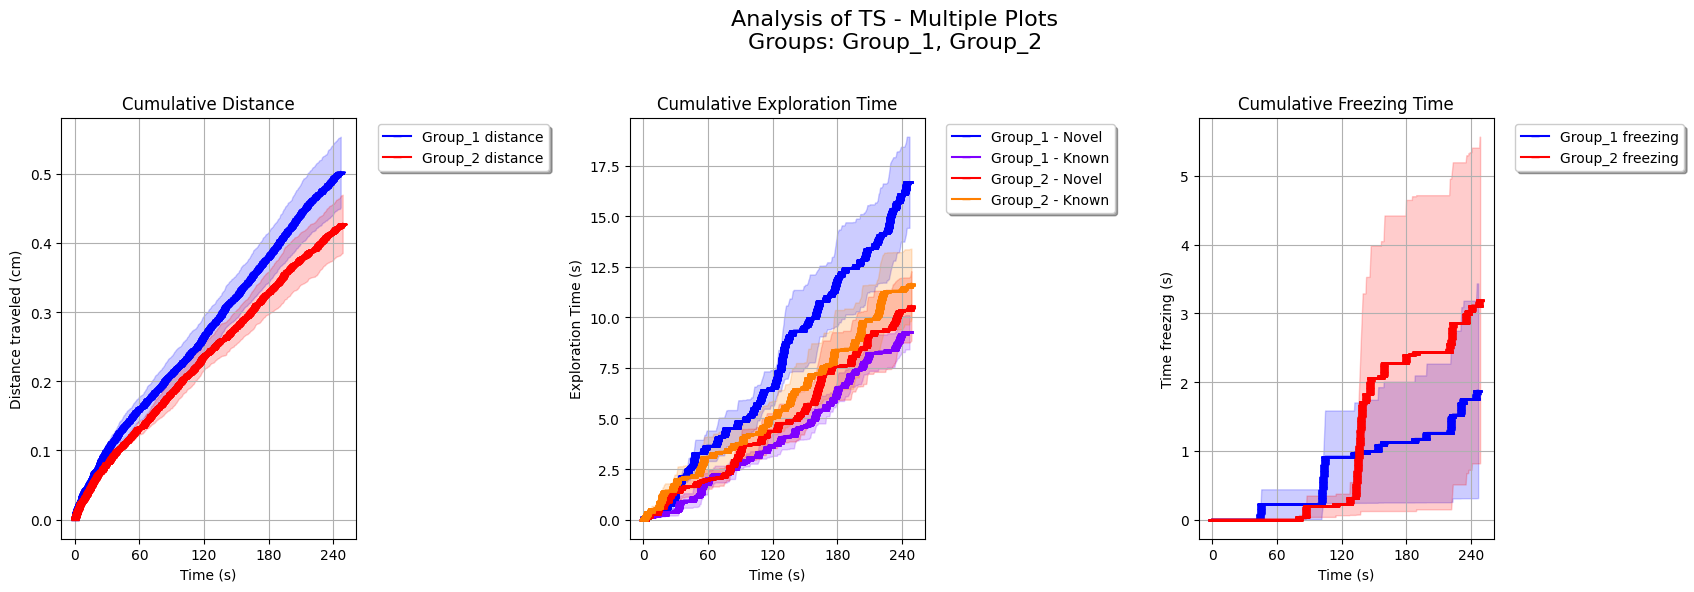

In [52]:
plot_multiple_analyses(params_file, trial='TS', plots=[lineplot_cumulative_distance, lineplot_cumulative_exploration_time, lineplot_cumulative_freezing_time])


---
#### 6. With our files ready, all is left to do is to run the analysis and plot the results.

We can plot:

    - lineplot_cumulative_distance
    - lineplot_freezing_cumulative_time
    - plot_freezing_boxplot
    - plot_freezing_histogram

    - lineplot_exploration_time
    - plot_binned_exploration_time
    - histogram_exploration_time

    - lineplot_exploration_cumulative_time
    - boxplot_exploration_cumulative_time
    - boxplot_exploration_proportion

    - plot_DI
    - boxplot_DI_area
    - plot_diff
    - boxplot_diff_area

    - scatterplot_exploration_cumulative_time
    - plot_roi_time
    - plot_alternations

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\examples\NOR\plots\TS_multiple_analyses_3.png


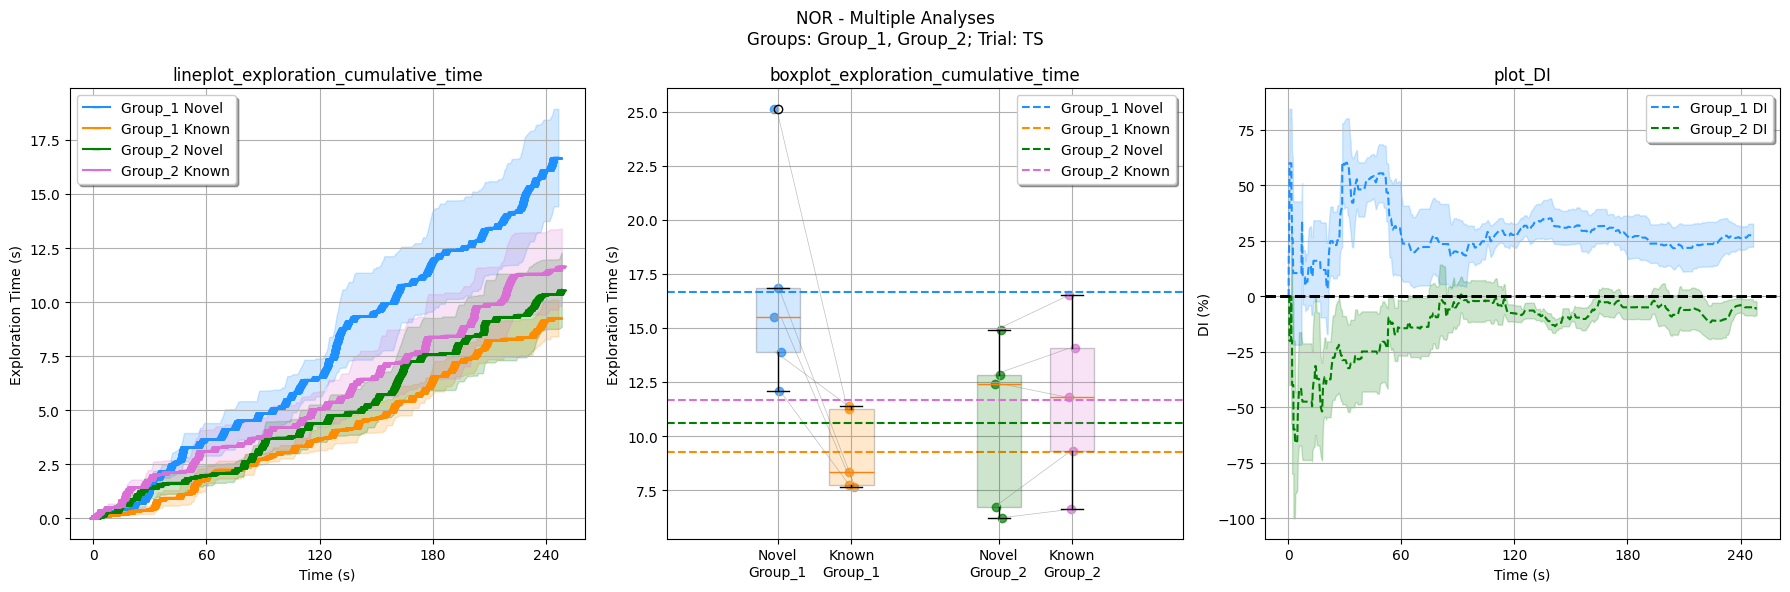

Plot saved at: C:\Users\dhers\Desktop\Rainstorm\examples\NOR\plots\TS_multiple_analyses_4.png


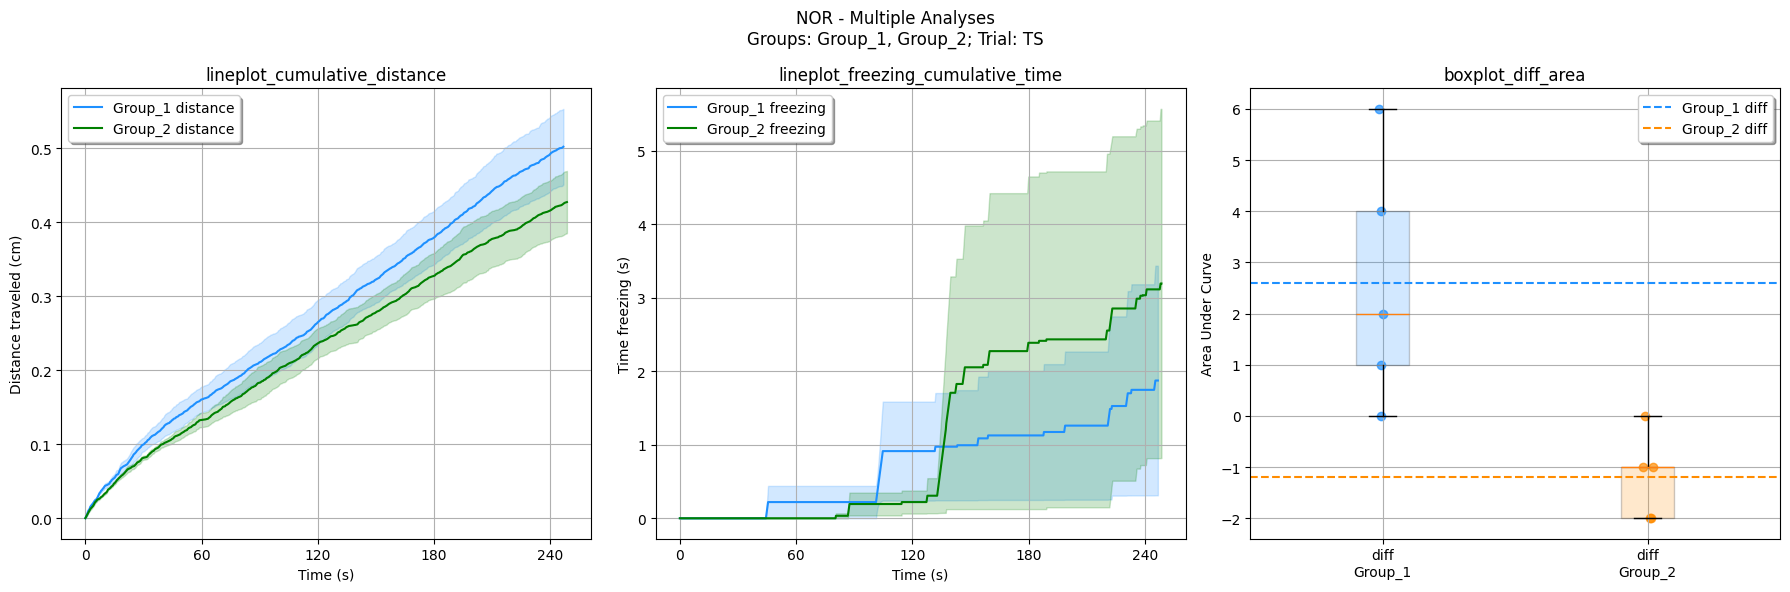

In [ ]:
rst.plot_multiple_analyses(params_file, trial='TS', plots=[rst.lineplot_exploration_cumulative_time, rst.boxplot_exploration_cumulative_time, rst.plot_DI])
rst.plot_multiple_analyses(params_file, trial='TS', plots=[rst.lineplot_cumulative_distance, rst.lineplot_freezing_cumulative_time, rst.boxplot_diff_area])



#### These modular graphs are intended to show the dynamic behavior of mice, providing a deeper insight into what happens during learning and memory.


---
#### 7. Make a csv file with the results of the experiment

The results.csv file will be stored in the experiment folder, and will contain columns for each of the variables plotted above. It is meant to be used for further statistical analysis.

In [8]:
rst.create_results_file(params_file)

Results file saved at C:\Users\dhers\Desktop\Rainstorm\examples\NOR\results.csv


WindowsPath('C:/Users/dhers/Desktop/Rainstorm/examples/NOR/results.csv')

---
#### 8. Bonus track... For each mouse, create individual plots

This function is thought particularly for experiments like Novel Object Recognition, since it only works properly if we have two targets on the arena.
The individual plots give us the chance to evaluate if something is off, and spot any behavioral outliers on both training and testing sessions.

You can test it with the demo data without problems, the plots will be stored in the example folder.

In [ ]:
rst.plot_all_individual_exploration(params_file)

No data for target novelty found for trial Hab. Skipping.
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R02_C2i.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R04_C2a.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R05_C3n.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R07_C3d.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R08_C4i.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R11_C5i.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R12_C5d.png
Plot saved at: C:\Users\dhers\OneDrive\Doctorado\Experimentos\BCI\BCI\plots\individual\2025_04-BCI-TR1-R14_C6i.png
Plot saved at: C:\User


We have reached the end of this project. If you have read and followed the code up to this point, I want to thank you for your time and attention.

If you have any questions and/or suggestions, do not hesitate to write: sdhers@fbmc.fcen.uba.ar


---
RAINSTORM - Created on Jun 25, 2024 - @author: Santiago D'hers